In [4]:
# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                             ExtraTreesRegressor, StackingRegressor,
                             HistGradientBoostingRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import joblib

# 1. Data Loading and Preparation with NaN handling
def load_and_prepare_data(filepath):
    """Load data and prepare power target using only provided columns"""
    df = pd.read_csv(filepath)

    # Calculate power using only provided sensor columns
    df['power'] = (
        0.5 * (df['a_max'] ** 2) * df['ax_rms'] +  # Linear energy component
        0.3 * (df['g_max'] ** 2) * df['gx_rms'] +  # Angular energy component
        0.2 * (df['ax_var'] + df['ay_var'] + df['az_var'])  # Jerk component
    )

    # Normalize power to 0-100 scale
    df['power'] = (df['power'] - df['power'].min()) / (df['power'].max() - df['power'].min()) * 100

    # Drop rows where power calculation resulted in NaN (if any)
    df = df.dropna(subset=['power'])

    return df

# 2. Date Feature Engineering
class DateTransformer(BaseEstimator, TransformerMixin):
    """Extract features from date column"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['date'] = pd.to_datetime(X['date'])
        X['year'] = X['date'].dt.year
        X['month'] = X['date'].dt.month
        X['day'] = X['date'].dt.day
        X['day_of_week'] = X['date'].dt.dayofweek
        return X.drop('date', axis=1)

# 3. Complete Preprocessing Pipeline with Imputation
def build_preprocessor():
    """Build preprocessing pipeline using only provided columns"""
    numeric_features = [
        'testmode', 'teststage', 'fileindex', 'count',
        'ax_mean', 'ay_mean', 'az_mean', 'gx_mean', 'gy_mean', 'gz_mean',
        'ax_var', 'ay_var', 'az_var', 'gx_var', 'gy_var', 'gz_var',
        'ax_rms', 'ay_rms', 'az_rms', 'gx_rms', 'gy_rms', 'gz_rms',
        'a_max', 'a_mean', 'a_min', 'g_max', 'g_mean', 'g_min',
        'a_fft', 'g_fft', 'a_psdx', 'g_psdx',
        'a_kurt', 'g_kurt', 'a_skewn', 'g_skewn',
        'a_entropy', 'g_entropy'
    ]

    categorical_features = [
        'gender', 'age', 'play years', 'height', 'weight',
        'handedness', 'hold racket handed'
    ]

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaN values
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle NaN values
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

# 4. Model Definitions with NaN-safe configurations
def get_models():
    """Return dictionary of models with faster parameter grids"""
    return {
        'Ridge': {
            'model': Ridge(),
            'params': {'regressor__alpha': [1.0]}  # Single best default value
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42, n_jobs=-1),
            'params': {
                'regressor__n_estimators': [100],  # Reduced from [100, 200]
                'regressor__max_depth': [10]       # Single sensible value
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingRegressor(random_state=42),
            'params': {
                'regressor__n_estimators': [100],  # Reduced from [100, 200]
                'regressor__learning_rate': [0.1],  # Single best default
                'regressor__max_depth': [3]         # Shallower tree for speed
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesRegressor(random_state=42, n_jobs=-1),
            'params': {
                'regressor__n_estimators': [100],  # Reduced from [100, 200]
                'regressor__max_depth': [10]        # Single sensible value
            }
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'regressor__C': [1.0],             # Single best default
                'regressor__kernel': ['rbf']        # Most commonly used kernel
            }
        },
        'KNN': {
            'model': KNeighborsRegressor(n_jobs=-1),
            'params': {
                'regressor__n_neighbors': [5],     # Single middle value
                'regressor__weights': ['distance']  # Typically better than uniform
            }
        },
        'MLP': {
            'model': MLPRegressor(max_iter=500, random_state=42),  # Reduced iterations
            'params': {
                'regressor__hidden_layer_sizes': [(50,)],  # Single simpler architecture
                'regressor__activation': ['relu']          # Most common choice
            }
        },
        'HistGradientBoosting': {
            'model': HistGradientBoostingRegressor(random_state=42),
            'params': {
                'regressor__max_iter': [100],      # Reduced from [100, 200]
                'regressor__learning_rate': [0.1], # Single best default
                'regressor__max_depth': [3]        # Shallower tree for speed
            }
        }
    }
    """Return dictionary of models with their parameter grids"""


# [Rest of the code remains the same from the previous implementation...]
# 5. Main Training Function
# 6. Visualization Function
# 7. Main Execution

if __name__ == "__main__":
    # Replace with your actual file path
    data_file = "/content/TTSWING.csv"

    # Run complete pipeline
    best_model, results = train_and_evaluate(data_file)

    print("\nTraining complete. Best model saved as 'best_stroke_power_model.pkl'")


Training Ridge...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Ridge - RMSE: 3.1935, R2: 0.8617

Training RandomForest...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
RandomForest - RMSE: 0.3480, R2: 0.9984

Training GradientBoosting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
GradientBoosting - RMSE: 0.3534, R2: 0.9983

Training ExtraTrees...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
ExtraTrees - RMSE: 0.3842, R2: 0.9980

Training SVR...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVR - RMSE: 1.4028, R2: 0.9733

Training KNN...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
KNN - RMSE: 1.2470, R2: 0.9789

Training MLP...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
MLP - RMSE: 0.1077, R2: 0.9998

Training HistGradientBoosting...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
HistGradientBoosting - RMSE: 0.4433, R2: 0.9973

Model Comparison:
                  Model      

In [35]:
model = joblib.load('best_stroke_power_model.pkl')
new_data = load_and_prepare_data('/content/TTSWING.csv')  # Update with your file path
power_min = new_data['power'].min()
power_max = new_data['power'].max()

# Prepare features (exclude power and id)
X_new = new_data.drop(['id', 'power'], axis=1, errors='ignore')

# 5. Make predictions (on normalized 0-100 scale)
normalized_predictions = model.predict(X_new)

# 6. Convert predictions back to original scale
actual_power_predictions = (
    normalized_predictions / 100 * (power_max - power_min) + power_min
)

# 7. Create comprehensive results dataframe
results = pd.DataFrame({
    'actual_power': new_data['power'] / 100 * (power_max - power_min) + power_min,
    'predicted_power': actual_power_predictions,
    'difference': (new_data['power'] / 100 * (power_max - power_min) + power_min - actual_power_predictions)
})

# 8. Save results
results.to_csv('power_predictions_actual_scale.csv', index=False)

# 9. Print sample results
print("Sample Predictions (Original Scale):")
print(results.head(10))

print(f"\nScaling Factors Used:")
print(f"Original Min Power: {power_min:.2f}")
print(f"Original Max Power: {power_max:.2f}")

Sample Predictions (Original Scale):
   actual_power  predicted_power  difference
0      0.019438         0.001582    0.017856
1      0.512733         0.559704   -0.046972
2      7.624381         7.272952    0.351429
3     11.393071        11.206978    0.186093
4     12.217741        12.074480    0.143261
5     14.521988        14.117068    0.404920
6     10.101573         9.945051    0.156523
7     12.232258        12.009912    0.222346
8     10.092639         9.927271    0.165368
9     12.025956        11.964008    0.061948

Scaling Factors Used:
Original Min Power: 0.00
Original Max Power: 100.00


In [36]:
saved_preds = pd.read_csv('power_predictions_actual_scale.csv')
saved_preds.head()

,actual_power,predicted_power,difference
0,0.019438,0.001582,0.017856
1,0.512733,0.559704,-0.046972
2,7.624381,7.272952,0.351429
3,11.393071,11.206978,0.186093
4,12.217741,12.074480,0.143261


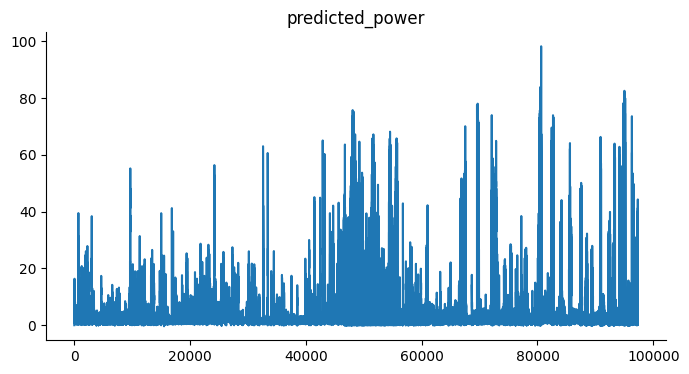

In [37]:
# @title predicted_power

from matplotlib import pyplot as plt
saved_preds['predicted_power'].plot(kind='line', figsize=(8, 4), title='predicted_power')
plt.gca().spines[['top', 'right']].set_visible(False)

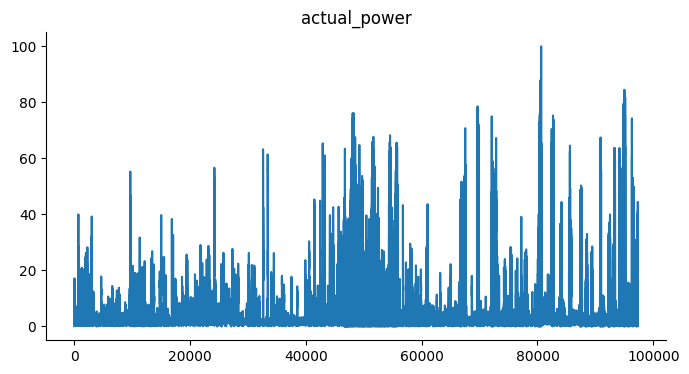

In [38]:
# @title actual_power

from matplotlib import pyplot as plt
saved_preds['actual_power'].plot(kind='line', figsize=(8, 4), title='actual_power')
plt.gca().spines[['top', 'right']].set_visible(False)

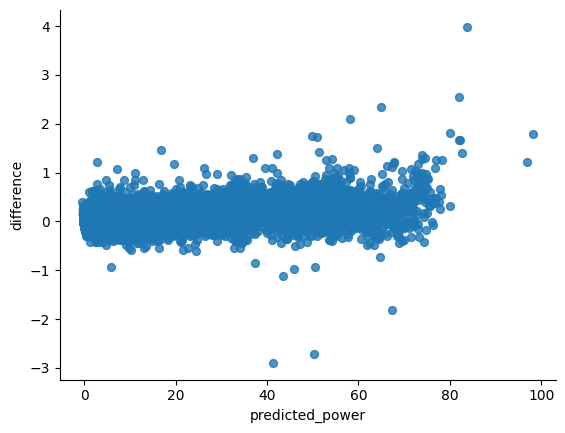

In [39]:
# @title predicted_power vs difference

from matplotlib import pyplot as plt
saved_preds.plot(kind='scatter', x='predicted_power', y='difference', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

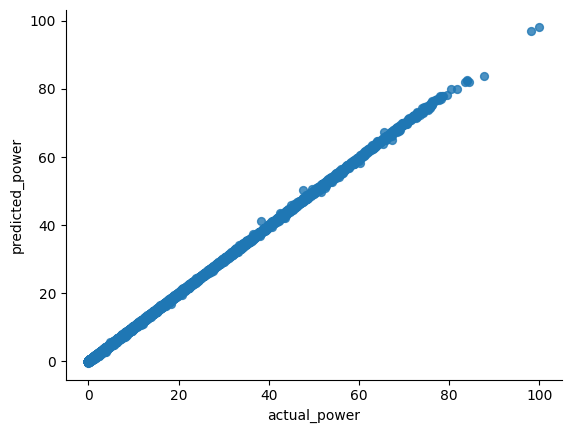

In [40]:
# @title actual_power vs predicted_power

from matplotlib import pyplot as plt
saved_preds.plot(kind='scatter', x='actual_power', y='predicted_power', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

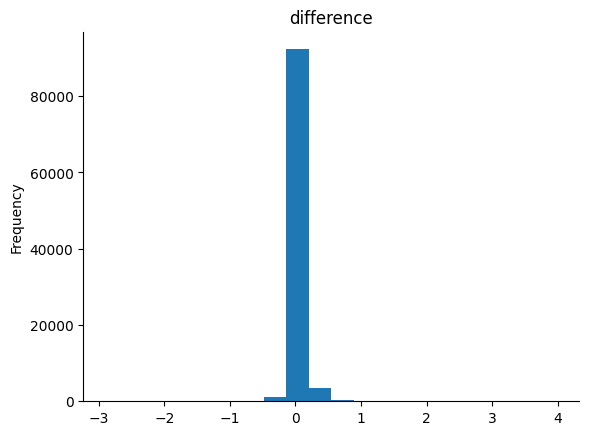

In [41]:
# @title difference

from matplotlib import pyplot as plt
saved_preds['difference'].plot(kind='hist', bins=20, title='difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

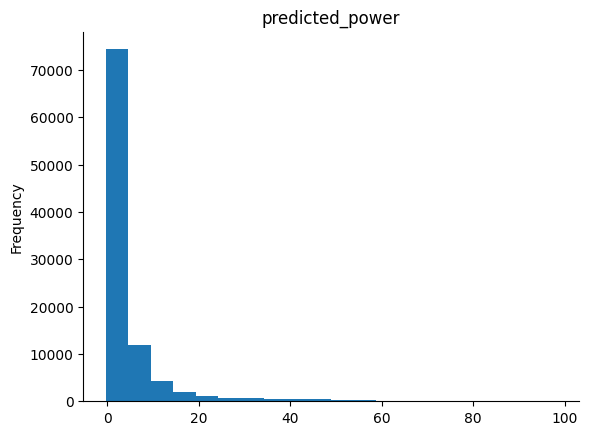

In [42]:
# @title predicted_power

from matplotlib import pyplot as plt
saved_preds['predicted_power'].plot(kind='hist', bins=20, title='predicted_power')
plt.gca().spines[['top', 'right',]].set_visible(False)

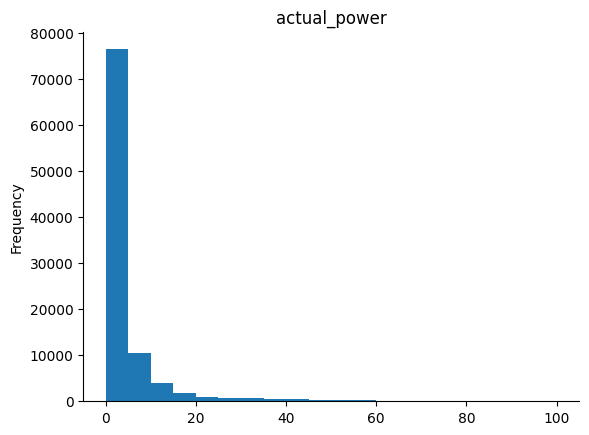

In [43]:
# @title actual_power

from matplotlib import pyplot as plt
saved_preds['actual_power'].plot(kind='hist', bins=20, title='actual_power')
plt.gca().spines[['top', 'right',]].set_visible(False)